#  Probability-Calibration:

When performing classification you often want to predict not only the class label, but also the associated probability. This probability gives you some kind of confidence on the prediction. However, not all classifiers provide well-calibrated probabilities, some being over-confident while others being under-confident. Thus, a separate calibration of predicted probabilities is often desirable as a postprocessing. This example illustrates two different methods for this calibration and evaluates the quality of the returned probabilities using Brier’s score 


In [1]:
!pip install ml_insights
!pip install betacal

     |████████████████████████████████| 24.8 MB 621 kB/s             
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.0 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0.2 which is incompatible.


In [2]:
###############################################################################
#                       Load Library                                          #
###############################################################################

#Load the librarys
import pandas as pd #To work with dataset
import numpy as np #Math library
import matplotlib.gridspec as gridspec
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
import warnings
# Preparation  
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer, StandardScaler,Normalizer,RobustScaler,MaxAbsScaler,MinMaxScaler,QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import KBinsDiscretizer
# Import StandardScaler from scikit-learn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer,IterativeImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline,FeatureUnion
from sklearn.manifold import TSNE
# Import train_test_split()
# Metrics
from sklearn.metrics import roc_auc_score, average_precision_score,recall_score
from sklearn.metrics import make_scorer,mean_absolute_error
from sklearn.metrics import mean_squared_error,classification_report,f1_score
from sklearn.metrics import roc_curve,confusion_matrix
from datetime import datetime, date
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.linear_model import LogisticRegression

#import tensorflow as tf 
#from tensorflow.keras import layers
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.callbacks import LearningRateScheduler
#import smogn
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone,ClassifierMixin
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
# For training random forest model
import lightgbm as lgb
from scipy import sparse
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# Model selection
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,f_classif,chi2
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_classif,VarianceThreshold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
import lightgbm as lgbm
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from xgboost import XGBClassifier,XGBRegressor
from sklearn import set_config
from itertools import combinations
# Cluster :
from sklearn.cluster import MiniBatchKMeans
#from yellowbrick.cluster import KElbowVisualizer
#import smong 
import category_encoders as ce
import warnings
#import optuna 
from joblib import Parallel, delayed
import joblib 
from sklearn import set_config
from typing import List, Optional, Union
import itertools
# Imbalanced data 
from imblearn.datasets import fetch_datasets
# to correctly set up the cross-validation
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    InstanceHardnessThreshold
)
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN,
    BorderlineSMOTE,
    SVMSMOTE,
)
# Calibration 
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    log_loss,
    plot_roc_curve,
)
import ml_insights as mli
from betacal import BetaCalibration
from sklearn.isotonic import IsotonicRegression
set_config(display='diagram')
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [3]:
mli.__version__

'0.1.8'


# Load the data

In [4]:
%%time 
###############################################################################
#                        Read train data                                      #
###############################################################################

train = pd.read_csv('../input/GiveMeSomeCredit/cs-training.csv')
test = pd.read_csv('../input/GiveMeSomeCredit/cs-test.csv')
train.head(3)

CPU times: user 247 ms, sys: 76.5 ms, total: 323 ms
Wall time: 455 ms


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0


# 1-Preprocessing

## Convert Dtypes :

In [5]:
###############################################################################
#                       Cast dtypes                                           #
###############################################################################

# Convert Dtypes :
train[train.select_dtypes(['int64','int16','float16','float32','float64','int8']).columns] = train[train.select_dtypes(['int64','int16','float16','float32','float64','int8']).columns].apply(pd.to_numeric)
train[train.select_dtypes(['object','category']).columns] = train.select_dtypes(['object','category']).apply(lambda x: x.astype('category'))
# Convert Dtypes :
test[test.select_dtypes(['int64','int16','float16','float32','float64','int8']).columns] = test[test.select_dtypes(['int64','int16','float16','float32','float64','int8']).columns].apply(pd.to_numeric)
test[test.select_dtypes(['object','category']).columns] = test.select_dtypes(['object','category']).apply(lambda x: x.astype('category'))

## Reduce Memory

In [6]:
###############################################################################
#                        Reduce Memory                                        #
###############################################################################

# Author : https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        name =df[col].dtype.name 
        
        if col_type != object and col_type.name != 'category':
        #if name != "category":    
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
train= reduce_mem_usage(train)
test= reduce_mem_usage(test)

Memory usage of dataframe is 13.73 MB
Memory usage after optimization is: 3.29 MB
Decreased by 76.0%
Memory usage of dataframe is 9.29 MB
Memory usage after optimization is: 2.90 MB
Decreased by 68.7%


## X and Y

In [7]:
# Cardinality : 
# - RevolvingUtilizationOfUnsecuredLines :125728, high Outlier
# - DebtRatio :114194 , high Outlier 
# deal with outlier + bin 
PERCENTAGE = ["RevolvingUtilizationOfUnsecuredLines", "DebtRatio"]
# MonthlyIncome:13594 , high outlier +bin 
REAL= ["MonthlyIncome"]
# Can be considred as cat 
NUMERIC_DISCRET_low = ["NumberOfDependents",
                       "NumberOfTime60-89DaysPastDueNotWorse",
                       "NumberRealEstateLoansOrLines",
                       "NumberOfTimes90DaysLate",
                       "NumberOfOpenCreditLinesAndLoans",
                       "NumberOfTime30-59DaysPastDueNotWorse",
                       "age"]
Late_Pay_Cols = ['NumberOfTime30-59DaysPastDueNotWorse',
                 'NumberOfTimes90DaysLate',
                 'NumberOfTime60-89DaysPastDueNotWorse']
TARGET = ["SeriousDlqin2yrs"]

#also change the type for TARGET to categorical
#df[TARGET] = df[TARGET].astype('category')

In [8]:
y = train['SeriousDlqin2yrs']

## Imput before Descritaziation : 

### IterativeImputer


In [9]:
%%time 
###############################################################################
#                        Impute Data                                          #
###############################################################################

param =  {   "verbosity": 0,
            #"objective": "binary:logistic",
            #"eval_metric": "auc",
            'random_state': 42,
            # regression
            'objective':'reg:squarederror', 
             'eval_metric': 'mae',
            #early_stopping_rounds=100 ,
           # 'gpu_id':0, 
           # 'predictor':"gpu_predictor",
            # use exact for small dataset.
            #"tree_method": "exact",
            # big data :
            # 'tree_method': 'gpu_hist',
            # defines booster, gblinear for linear functions.
             'booster': 'gbtree', 
            'lambda': 8.544792472633987e-07,
            'alpha': 0.31141671752487043,
            'subsample': 0.8779467596981366, 
            'colsample_bytree': 0.9759532762677546,
            'learning_rate': 0.008686087328805853, 
            'n_estimators': 6988,
            'max_depth': 9,
            'min_child_weight': 2, 
            'eta': 3.7603213457541647e-06,
            'gamma': 2.1478058456847449e-07,
            'grow_policy': 'lossguide'}
                

#model_xgb = XGBRegressor(
       #objective="mae",
 #   **xgb_params2)

numeric_transformer1 = Pipeline(
                            steps=[
                            ('imputer', SimpleImputer(strategy='median'
                                                      ,add_indicator=True)),
                            ('scaler', PowerTransformer()),#(Numerical Input, Numerical Output)
                            # Create an SelectKBest object to select features with two best ANOVA F-Values
                            #The F-value scores examine if, when we group the numerical feature by the target vector, the means for each group are significantly different
                           # ('reducedim',  SelectPercentile(f_classif,percentile=90))
                            ]
                            )
numeric_transformer2 = Pipeline(
                            steps=[
                            #('imputer', SimpleImputer(strategy='median'
                             #                         ,add_indicator=True)),
                            ('scaler', PowerTransformer()),#(Numerical Input, Numerical Output)
                            # Create an SelectKBest object to select features with two best ANOVA F-Values
                            #The F-value scores examine if, when we group the numerical feature by the target vector, the means for each group are significantly different
                           # ('reducedim',  SelectPercentile(f_classif,percentile=90))
                            ]
                            )

pipe_xgbr1 = Pipeline(
                    steps=[
                        ('preprocessor', numeric_transformer1),
                        ('classifier', XGBRegressor(
                      #objective="mae",
                       **param))
                    ]
                )
pipe_xgbr2 = Pipeline(
                    steps=[
                        ('preprocessor', numeric_transformer2),
                        ('classifier', XGBRegressor(
                      #objective="mae",
                       **param))
                    ]
                )

CPU times: user 356 µs, sys: 0 ns, total: 356 µs
Wall time: 361 µs


In [10]:
%%time 
train=train.drop(['Unnamed: 0','SeriousDlqin2yrs'], axis=1)
test=test.drop(['Unnamed: 0','SeriousDlqin2yrs'], axis=1)
train_final= pd.concat( [train, test], axis=0) 
#testdf_income= train_final[train_final['MonthlyIncome'].isnull()==True]
traindf_income = train_final[train_final['MonthlyIncome'].isnull()==False]
y_income = traindf_income['MonthlyIncome']
X_income=traindf_income.drop(["MonthlyIncome"],axis=1)
pipe_xgbr1.fit(X_income, y_income)
train_income_missing=train[train['MonthlyIncome'].isnull()==True].drop(["MonthlyIncome"],axis=1)
test_income_missing=test[test['MonthlyIncome'].isnull()==True].drop(["MonthlyIncome"],axis=1)
train_predicted = pipe_xgbr1.predict(train_income_missing)
test_predicted = pipe_xgbr1.predict(test_income_missing)
train.loc[(train.MonthlyIncome.isnull()), 'MonthlyIncome'] = train_predicted
test.loc[(test.MonthlyIncome.isnull()), 'MonthlyIncome'] = test_predicted

CPU times: user 1h 14min 47s, sys: 7.19 s, total: 1h 14min 54s
Wall time: 19min 13s


In [11]:
%%time 
traindf_NumberOfDependents = train_final[train_final['NumberOfDependents'].isnull()==False]
y_NumberOfDependents = traindf_NumberOfDependents['NumberOfDependents']
X_NumberOfDependents=traindf_NumberOfDependents.drop(["NumberOfDependents"],axis=1)
pipe_xgbr2.fit(X_NumberOfDependents, y_NumberOfDependents)
train_NumberOfDependents_missing=train[train['NumberOfDependents'].isnull()==True].drop(["NumberOfDependents"],axis=1)
test_NumberOfDependents_missing=test[test['NumberOfDependents'].isnull()==True].drop(["NumberOfDependents"],axis=1)
train_predicted = pipe_xgbr2.predict(train_NumberOfDependents_missing)
test_predicted = pipe_xgbr2.predict(test_NumberOfDependents_missing)
train.loc[(train.NumberOfDependents.isnull()), 'NumberOfDependents'] = train_predicted
test.loc[(test.NumberOfDependents.isnull()), 'NumberOfDependents'] = test_predicted

CPU times: user 1h 30min 23s, sys: 7.19 s, total: 1h 30min 30s
Wall time: 23min 11s


In [12]:
###############################################################################
#                        Add Bin Features                                     #
###############################################################################

# Add bin data 
# initializing append_str
append_str = 'cat_'
# Append suffix / prefix to strings in list
num_features1=["RevolvingUtilizationOfUnsecuredLines", "DebtRatio","MonthlyIncome"]
num_features2=["NumberOfDependents",
                       "NumberOfTime60-89DaysPastDueNotWorse",
                       "NumberRealEstateLoansOrLines",
                       "NumberOfTimes90DaysLate",
                       "NumberOfOpenCreditLinesAndLoans",
                       "NumberOfTime30-59DaysPastDueNotWorse",
                       "age"]
cat_features1 = [append_str + sub for sub in num_features1]
cat_features2 = [append_str + sub for sub in num_features2]

# create the discretizer object with strategy quantile and 1000 bins
discretizer1 = KBinsDiscretizer(n_bins=40, encode='ordinal',strategy='quantile')
discretizer2 = KBinsDiscretizer(n_bins=4, encode='ordinal',strategy='quantile')

pipeline1 = Pipeline([
        ('imputer', SimpleImputer( strategy='median')),
        ('bin', discretizer1)
    ])
# fit the discretizer to the train set
pipeline1.fit(train.loc[:,num_features1])
# apply the discretisation
train_cat1 = pipeline1.transform(train.loc[:,num_features1])
test_cat1 = pipeline1.transform(test.loc[:,num_features1])
train_df1=pd.DataFrame(train_cat1,columns=cat_features1).astype('category')
test_df1=pd.DataFrame(test_cat1,columns=cat_features1).astype('category')
train_final1= pd.concat( [train.loc[:,num_features1], train_df1], axis=1) 
test_final1= pd.concat( [test.loc[:,num_features1], test_df1], axis=1) 

pipeline2 = Pipeline([
        ('imputer', SimpleImputer( strategy='median')),
        ('bin', discretizer2)
    ])
# fit the discretizer to the train set
pipeline2.fit(train.loc[:,num_features2])
# apply the discretisation
train_cat2 = pipeline2.transform(train.loc[:,num_features2])
test_cat2 = pipeline2.transform(test.loc[:,num_features2])
train_df2=pd.DataFrame(train_cat2,columns=cat_features2).astype('category')
test_df2=pd.DataFrame(test_cat2,columns=cat_features2).astype('category')
train_final2= pd.concat( [train.loc[:,num_features2], train_df2], axis=1) 
test_final2= pd.concat( [test.loc[:,num_features2], test_df2], axis=1) 
train_final= pd.concat( [train_final1, train_final2], axis=1) 
test_final= pd.concat( [test_final1, test_final2], axis=1) 

## Final X and y

In [13]:
###############################################################################
#                        Final X and Y                                    #
###############################################################################

# Pour le train test
target= "SeriousDlqin2yrs"
X = train_final# axis=1
X_test_final =test_final# axis=1

In [14]:
del train
del test 
del train_final
del test_final

In [15]:
###############################################################################
#                        Select Dtypes                                         #
###############################################################################

# select non-numeric columns
cat_columns = X.select_dtypes(exclude=['int64','int16','float16','float32','float64','int8']).columns
cat_columns

Index(['cat_RevolvingUtilizationOfUnsecuredLines', 'cat_DebtRatio',
       'cat_MonthlyIncome', 'cat_NumberOfDependents',
       'cat_NumberOfTime60-89DaysPastDueNotWorse',
       'cat_NumberRealEstateLoansOrLines', 'cat_NumberOfTimes90DaysLate',
       'cat_NumberOfOpenCreditLinesAndLoans',
       'cat_NumberOfTime30-59DaysPastDueNotWorse', 'cat_age'],
      dtype='object')

### Num Features



In [16]:
###############################################################################
#                        Select Dtypes                                         #
###############################################################################

# select the float columns
num_columns = X.select_dtypes(include=['int64','int16','float16','float32','float64','int8']).columns
num_columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome',
       'NumberOfDependents', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberRealEstateLoansOrLines', 'NumberOfTimes90DaysLate',
       'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTime30-59DaysPastDueNotWorse', 'age'],
      dtype='object')

# FE

In [17]:
###############################################################################
#                       Fe Class                                              #
###############################################################################

class MiniKmeansTransformerEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, num_clusters = 11, encoder=ce.woe.WOEEncoder()):
        self.num_clusters = num_clusters
        self.encoder= encoder
        if self.num_clusters > 0:
            self.kmeans = MiniBatchKMeans(n_clusters=self.num_clusters, random_state=0)
    
    def fit(self, X, y=None):
        if self.num_clusters > 0:
            self.kmeans.fit(X)
            preds=self.kmeans.predict(X)
            preds=pd.DataFrame(preds, columns=['kmeans']).astype('category')
            self.encoder.fit(preds,y)
        return self
    
    def transform(self, X, y=None):
        pred_classes = self.kmeans.predict(X)
        pred_classes=pd.DataFrame(pred_classes, columns=['kmeans']).astype('category')
        pred_encoded = self.encoder.transform(pred_classes)
        return np.hstack((X, pred_encoded))
        #return pred_encoded

# Complete Pipe 

1. Features Engineer

1. Kmeans

1. Sparse

1. Poly

1. Scaler/Transformer

1. imput

1. Add bin data 

## Pipe : 


In [18]:
###############################################################################
#                       Final Selected Pipes                                          #
###############################################################################

# Cat pipeline
categorical_transformer = Pipeline(
                    steps=[
                        ('imputer', SimpleImputer(strategy='most_frequent',
                                                  fill_value='missing',
                                                  add_indicator=True)),
                        ('encoder',  ce.woe.WOEEncoder()),#(Numerical Input, Categorical Output)
                        #('sparse_features', SparseInteractions(degree=2)),
                        #('reducedim',  SelectPercentile( mutual_info_classif, percentile=90))

                    ]
                    ) 
#Define vnum pipeline
numeric_transformer = Pipeline(
                            steps=[
                            ('imputer', SimpleImputer(strategy='median'
                                                      ,add_indicator=True)),
                            #('general_features',FeaturesEngineer()),
                            ('scaler', PowerTransformer()),#(Numerical Input, Numerical Output)
                            # Create an SelectKBest object to select features with two best ANOVA F-Values
                            #The F-value scores examine if, when we group the numerical feature by the target vector, the means for each group are significantly different
                            ('kmeans',MiniKmeansTransformerEncoder()),
                            ('polynominal_features', PolynomialFeatures(degree=2)),
                            #('reducedim',  SelectPercentile(f_classif,percentile=90))
                            ]
                            )
# Features union cat + num 
# WOE+PowerTransformer
preprocessor_woe_powertransformer = ColumnTransformer(
            transformers=[
                ('numerical', numeric_transformer, num_columns),
               # ('categorical', categorical_transformer, cat_columns)
            ])

In [19]:
lgbm_param2={'learning_rate': 0.0018069834369607075,
                                 'max_depth': 8,
                                 #'max_features': 4,
                                 'min_samples_leaf': 47,
                                 #'min_samples_split': 389,
                                 'subsample': 0.8573598985000007,
                                 #'n_iter_no_change': 300,
                                 'n_estimators': 5000,
                                 'verbose': -1,
                                 'random_state': 42,
                                 'metric': 'auc',
                               # "device_type" : "gpu",
                                'boosting_type': 'gbdt',
                                #'tree_method': "gpu_hist"
                               }

model_lgbm2 = lgbm.LGBMClassifier(**lgbm_param2,
                              # use it  only on gpu
                            # rsm=np.nan
                              #cat_features=cat_features
                             )
pipe1_model_lgbm_woe_powertransformer2 = Pipeline(
    steps=[
        ('preprocessor', preprocessor_woe_powertransformer),
         ('reducedim',  SelectPercentile( f_classif, percentile=95)),
        # ('dim_red', SelectKBest(f_regression, k=20)),
        #('Sparseinteractions', SparseInteractions(degree=2)),
         #('PolynomialFeatures', PolynomialFeatures(degree=2)),
        #('PCAreducer', PCA(n_components=0.8)),
        ('classifier',model_lgbm2)
    ]
)
#pipe1_model_lgbm_woe_powertransformer2

# Final Pipe : 

In [20]:
###############################################################################
#                        Final Pipe                                          #
###############################################################################

#Define vnum pipeline
numeric_transformer_final = Pipeline(
                            steps=[
                            ('imputer', SimpleImputer(strategy='median'
                                                      ,add_indicator=True)),
                            #('general_features',FeaturesEngineer()),
                            ('scaler', PowerTransformer()),#(Numerical Input, Numerical Output)
                            # Create an SelectKBest object to select features with two best ANOVA F-Values
                            #The F-value scores examine if, when we group the numerical feature by the target vector, the means for each group are significantly different
                            ('kmeans',MiniKmeansTransformerEncoder()),
                            ('polynominal_features', PolynomialFeatures(degree=2)),
                            ('reducedim',  SelectPercentile(f_classif,percentile=95)),
                            #('scaler_minmax',MinMaxScaler())
                            ]
                            )
# Features union cat + num 
# WOE+PowerTransformer
preprocessor_woe_powertransformer_final = ColumnTransformer(
            transformers=[
                ('numerical', numeric_transformer_final, num_columns),
               # ('categorical', categorical_transformer, cat_columns)
               
            ])
preprocessor_woe_powertransformer_final

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median')),
                                                 ('scaler', PowerTransformer()),
                                                 ('kmeans',
                                                  MiniKmeansTransformerEncoder()),
                                                 ('polynominal_features',
                                                  PolynomialFeatures()),
                                                 ('reducedim',
                                                  SelectPercentile(percentile=95))]),
                                 Index(['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome',
       'NumberOfDependents', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberRealEstateLoansOrLines', 'NumberOfTimes90DaysLate',
       'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTime30-59DaysPastDueNotWorse', 'age'],
      dtype='object'))])

In [21]:
###############################################################################
#                         Preprocess                                          #
###############################################################################
preprocessor_woe_powertransformer_final.fit(X,y)
x_pre = preprocessor_woe_powertransformer_final.transform(X)
x_test_final_pre = preprocessor_woe_powertransformer_final.transform(X_test_final)
###############################################################################
#                                  Get data                                   #
###############################################################################
X_train,X_test, y_train,  y_test = train_test_split(x_pre, y,stratify=y, 
                                                       test_size=0.2,
                                                        random_state=42,
                                                        shuffle=True)

# Probability Calibration 
##  Probability Calibration Curve
Probability calibration curves allow us to visualize if the probability is calibrated.

**LR**


In [22]:
# Logistic Regression on balanced dataset
logit = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    C=1,
    random_state=0,
    max_iter=100,
).fit(X_train, y_train)

# score the test set
probs = logit.predict_proba(X_test)[:, 1]

Sorts the probability values into bins

Determines the true positive fraction in those bins

In [23]:
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, probs, n_bins=10, strategy='uniform')

len(mean_predicted_value), len(fraction_of_positives)

(9, 9)

In [24]:
# mean probability of each interval / bin
mean_predicted_value

array([0.02663447, 0.13936882, 0.24474612, 0.34977265, 0.44685529,
       0.5454302 , 0.63809066, 0.72827951, 0.8465907 ])

In [25]:
# fraction of observations of the minority class
# in each interval of probability
fraction_of_positives

array([0.02668153, 0.13476127, 0.25841477, 0.37164179, 0.44664032,
       0.55647383, 0.59731544, 0.72222222, 1.        ])

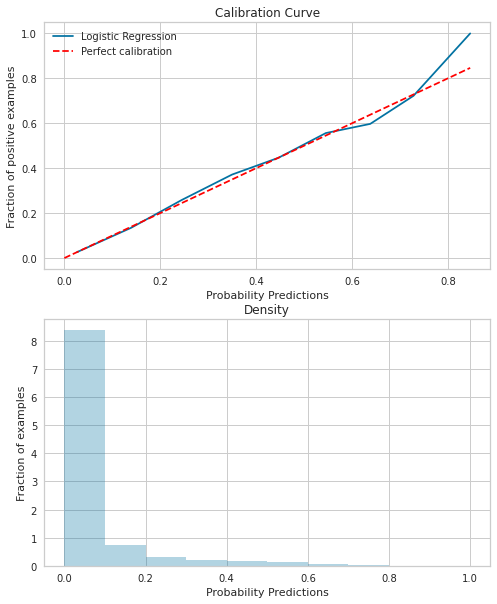

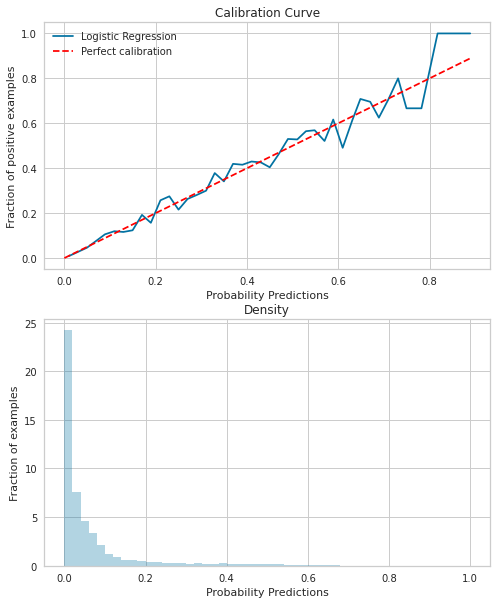

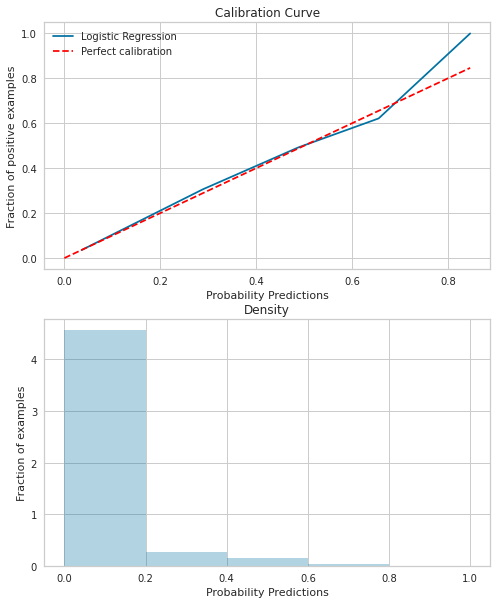

In [26]:
# bring all together
def plot_calibration_curve0(y_true, probs, bins, strategy):

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, probs, n_bins=bins, strategy=strategy)
    
    max_val = max(mean_predicted_value)
    
    plt.figure(figsize=(8,10))
    plt.subplot(2, 1, 1)
    plt.plot(mean_predicted_value, fraction_of_positives, label='Logistic Regression')
    plt.plot(np.linspace(0, max_val, bins), np.linspace(0, max_val, bins),
         linestyle='--', color='red', label='Perfect calibration')
    
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')
    plt.title('Calibration Curve')
    plt.legend(loc='upper left')


    plt.subplot(2, 1, 2)
    plt.hist(probs, range=(0, 1), bins=bins, density=True, stacked=True, alpha=0.3)
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of examples')
    plt.title('Density')
    plt.show()
plot_calibration_curve0(y_test, probs, bins=10, strategy='uniform')  
#Change number of probability bins
plot_calibration_curve0(y_test, probs, bins=50, strategy='uniform')
plot_calibration_curve0(y_test, probs, bins=5, strategy='uniform')     

The less observations we have per interval, the harder to obtain a reliable probability vs positive fraction estimate. This, the functions seems more noisy. 

# Assessing Calibration
## Brier Score
The Brier Score measures the fit of the probability estimates of the observed data. It is given by the average squared difference of the true label and the predicted probability.

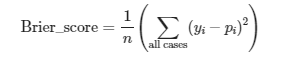

**Brier Score = mean( (y -pred)^2 )**

Brier score is a fancy name for the mean squared error between the predicted probabilities and the true (0/1) answer. If I predict .7 on a case that was true (1), my error for that case is 0.09

Average the scores on all cases, and that gives the Brier score.

Note that the "worst case" for Brier score is 1, whereas for log-loss it is .
i will talk about log loss after 



[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
roc-auc of  LogisticRegression 0.8645447107361085
roc-auc of  GaussianNB 0.8307542449466617
roc-auc of  LGBMClassifier 0.8673752749756257


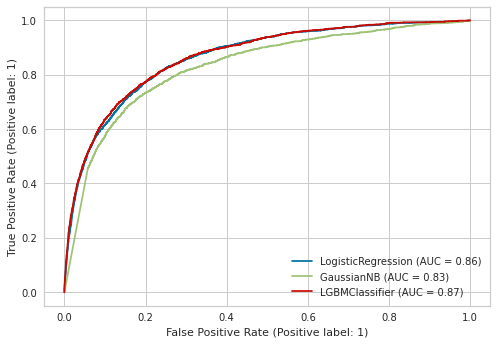

In [27]:
### Set up models
# Logistic Regression

logit = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    C=1,
    random_state=0,
    max_iter=100,
).fit(X_train, y_train)


# naive Bayes
bayes = GaussianNB().fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=10,
    random_state=0,
).fit(X_train, y_train)

# LGBM
lgbmc =  model_lgbm2.fit(X_train, y_train)
for model in [logit, bayes, lgbmc]:
    
    # obtain predictions
    probs = model.predict_proba(X_test)[:, 1]
    
    # print roc-auc
    print('roc-auc of ', type(model).__name__, roc_auc_score(y_test, probs))
ax = plt.gca()
for model in [logit, bayes, lgbmc]:
    
    # plot ROC curve
    tmp_disp = plot_roc_curve(model, X_test, y_test, ax=ax)     

The LGBMClassifier  seems to perform slightly better than Logistic Regression, and Naive Bayes has a tiny worse performance.

In [28]:
for model in [logit, bayes,  lgbmc]:

    # obtain predictions
    probs = model.predict_proba(X_test)[:, 1]

    # print roc-auc
    print('Brier Score of ', type(model).__name__,
          brier_score_loss(y_test, probs))

Brier Score of  LogisticRegression 0.049476913685574074
Brier Score of  GaussianNB 0.09607337609126794
Brier Score of  LGBMClassifier 0.04879177395905705


From the Brier Score, we see that LGBMClassifier Machines show the highest performance, it Brier Score is bigger, suggesting that its probabilities are  well calibrated.

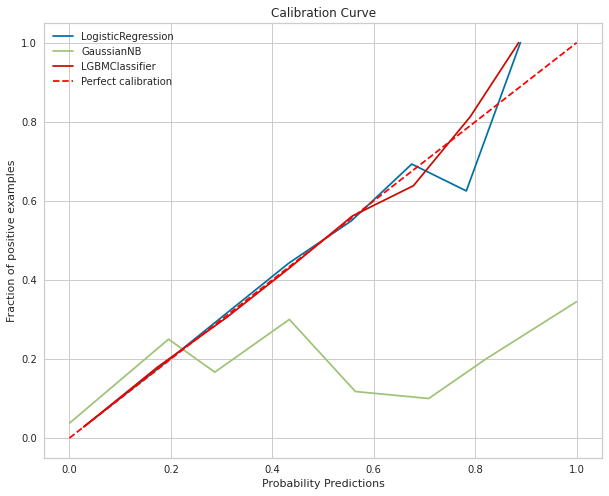

In [29]:
def plot_calibration_curve(bins):

    plt.figure(figsize=(10, 8))

    for model in [logit, bayes,  lgbmc]:

        # obtain predictions
        probs = model.predict_proba(X_test)[:, 1]

        # obtain calibration curve parameters
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, probs, n_bins=bins, strategy='uniform')

        plt.plot(mean_predicted_value, fraction_of_positives,
                 label=type(model).__name__)

    # add perfectly calibrated predictions
    plt.plot(np.linspace(0, 1, bins), np.linspace(0, 1, bins),
             linestyle='--', color='red', label='Perfect calibration')

    # add labels
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')
    plt.title('Calibration Curve')
    plt.legend(loc='upper left')

    # show
    plt.show()
plot_calibration_curve(bins=8)    
    

As expected, Naive Bayes  Machines show the worse calibration.

**Probability Re-calibration:**

In [30]:
# Isotonic calibration
clf_isotonic = CalibratedClassifierCV(model_lgbm2, cv=5, method='isotonic')
clf_isotonic.fit(X_test, y_test)
prob_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# Sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(model_lgbm2, cv=5, method='sigmoid')
clf_sigmoid.fit(X_test, y_test)
prob_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_

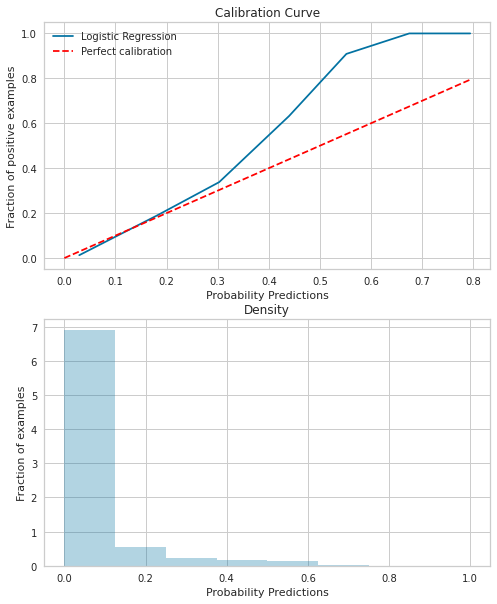

In [31]:
plot_calibration_curve0(y_test, prob_isotonic, bins=8, strategy='uniform')

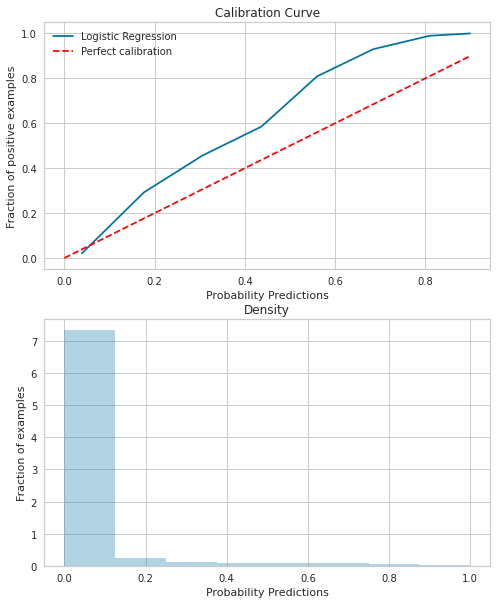

In [32]:
plot_calibration_curve0(y_test, prob_sigmoid, bins=8, strategy='uniform')

The Plat Scaling worked better than Isotonic Calibration 

Brier score losses: (the smaller the better)
No calibration: 0.096
With isotonic calibration: 0.053
With sigmoid calibration: 0.054


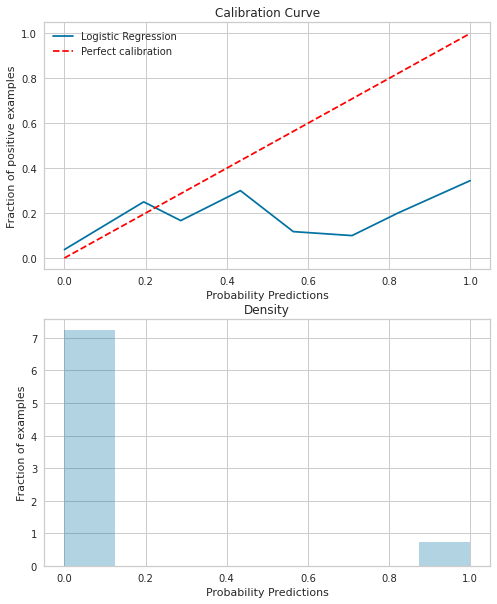

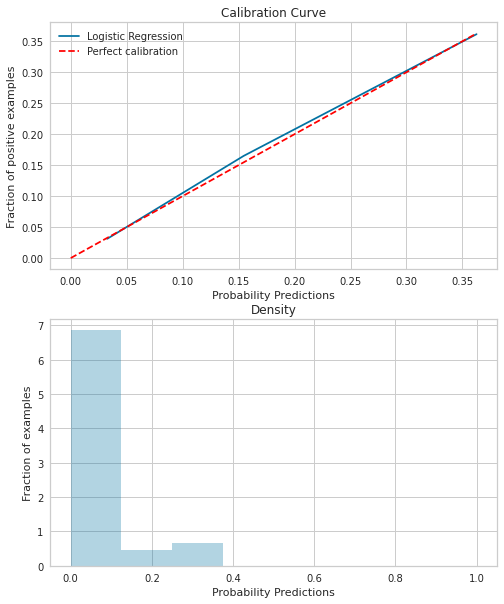

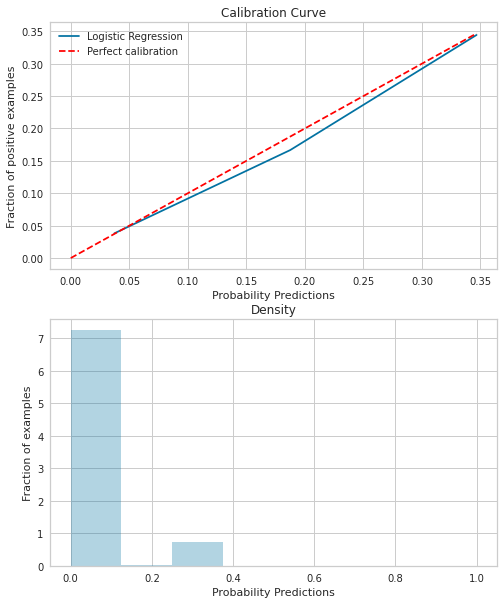

In [33]:
# Gaussian Naive-Bayes with no calibration
clf = GaussianNB()
clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(X_test)[:, 1]
# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method="isotonic")
clf_isotonic.fit(X_train, y_train
                # ,sample_weight=sw_train
                )
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]
# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method="sigmoid")
clf_sigmoid.fit(X_train, y_train
                #,sample_weight=sw_train
               )
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]
print("Brier score losses: (the smaller the better)")
clf_score = brier_score_loss(y_test, prob_pos_clf
                             #, sample_weight=sw_test
                            )
print("No calibration: %1.3f" % clf_score)
clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic,
                                      #sample_weight=sw_test
                                     )
print("With isotonic calibration: %1.3f" % clf_isotonic_score)
clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid
                                     #,sample_weight=sw_test
                                    )
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)
plot_calibration_curve0(y_test, prob_pos_clf, bins=8, strategy='uniform')
plot_calibration_curve0(y_test, prob_pos_isotonic, bins=8, strategy='uniform')
plot_calibration_curve0(y_test, prob_pos_sigmoid, bins=8, strategy='uniform')


Isonic do the best calibration for naive machine

# LR

Brier score losses: (the smaller the better)
No calibration: 0.049
With isotonic calibration: 0.050
With sigmoid calibration: 0.049


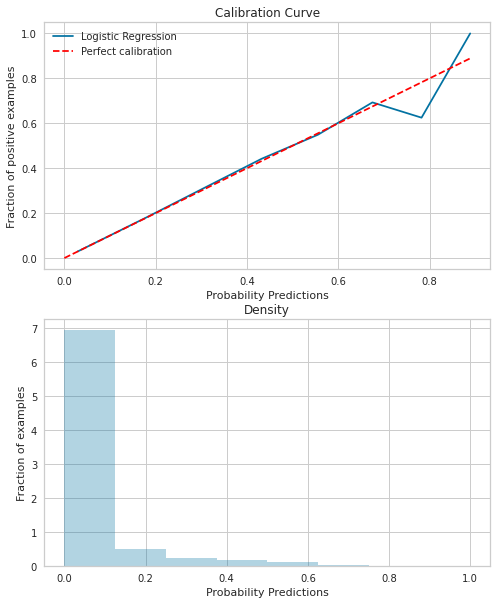

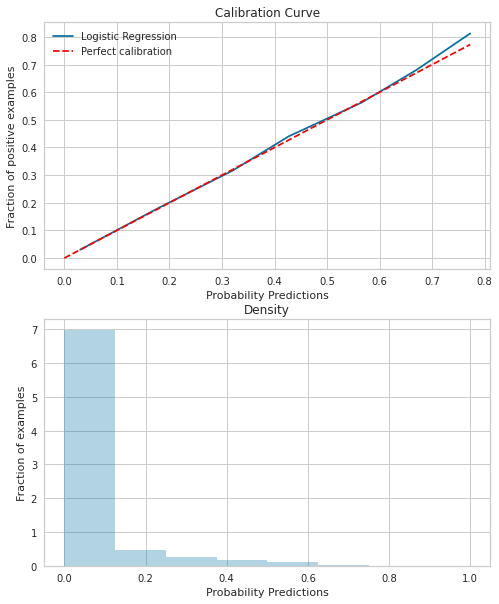

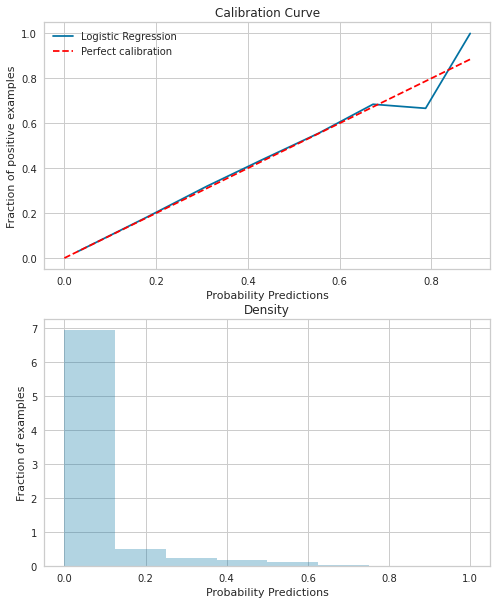

In [34]:
# Gaussian Logistic Regression  with no calibration
clf = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    C=1,
    random_state=0,
    max_iter=100,
)

clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(X_test)[:, 1]
# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=5, method="isotonic")
clf_isotonic.fit(X_train, y_train
                # ,sample_weight=sw_train
                )
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]
# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=5, method="sigmoid")
clf_sigmoid.fit(X_train, y_train
                #,sample_weight=sw_train
               )
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]
print("Brier score losses: (the smaller the better)")
clf_score = brier_score_loss(y_test, prob_pos_clf
                             #, sample_weight=sw_test
                            )
print("No calibration: %1.3f" % clf_score)
clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic,
                                      #sample_weight=sw_test
                                     )
print("With isotonic calibration: %1.3f" % clf_isotonic_score)
clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid
                                     #,sample_weight=sw_test
                                    )
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)
plot_calibration_curve0(y_test, prob_pos_clf, bins=8, strategy='uniform')
plot_calibration_curve0(y_test, prob_pos_isotonic, bins=8, strategy='uniform')
plot_calibration_curve0(y_test, prob_pos_sigmoid, bins=8, strategy='uniform')


# LGBM

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_

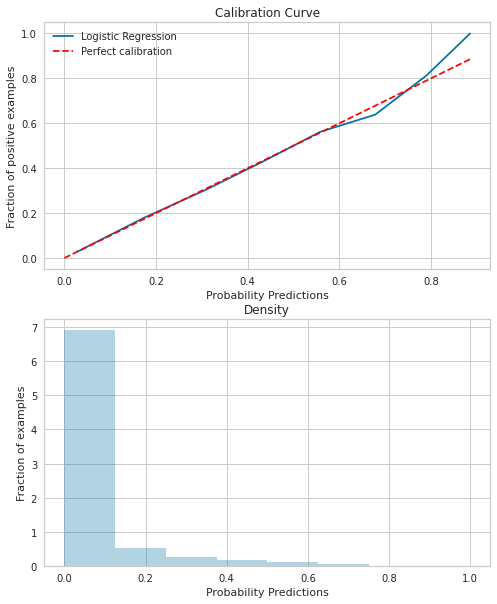

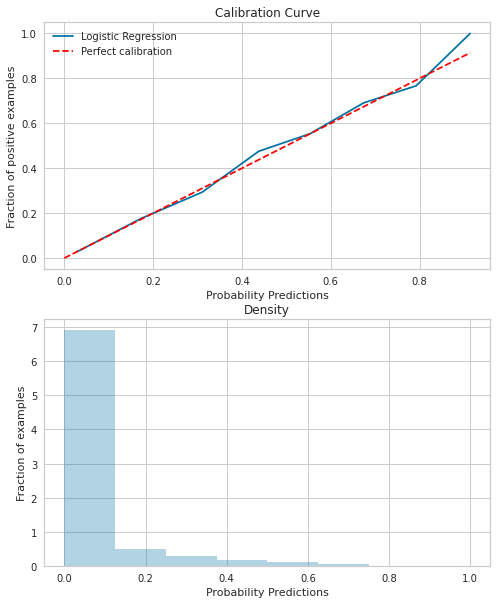

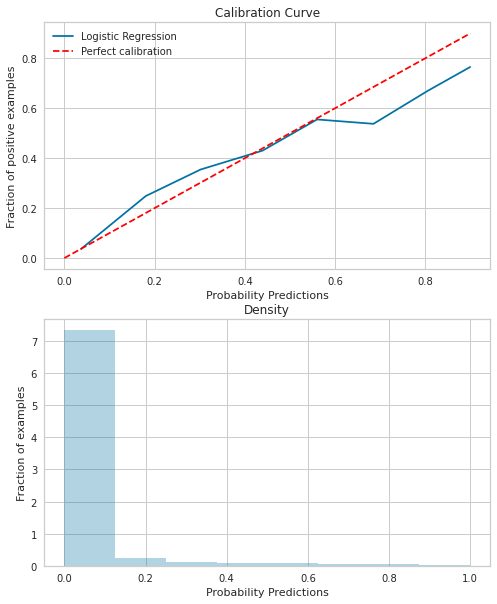

In [35]:
# Gaussian Logistic Regression  with no calibration
clf = model_lgbm2

clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(X_test)[:, 1]
# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=5, method="isotonic")
clf_isotonic.fit(X_train, y_train
                # ,sample_weight=sw_train
                )
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]
# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=5, method="sigmoid")
clf_sigmoid.fit(X_train, y_train
                #,sample_weight=sw_train
               )
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]
print("Brier score losses: (the smaller the better)")
clf_score = brier_score_loss(y_test, prob_pos_clf
                             #, sample_weight=sw_test
                            )
print("No calibration: %1.3f" % clf_score)
clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic,
                                      #sample_weight=sw_test
                                     )
print("With isotonic calibration: %1.3f" % clf_isotonic_score)
clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid
                                     #,sample_weight=sw_test
                                    )
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)
plot_calibration_curve0(y_test, prob_pos_clf, bins=8, strategy='uniform')
plot_calibration_curve0(y_test, prob_pos_isotonic, bins=8, strategy='uniform')
plot_calibration_curve0(y_test, prob_pos_sigmoid, bins=8, strategy='uniform')

# Bonus
## Credit acceptance rates
Here's an example using our test data. If we want to accept 85% of all loans with the lowest probabilities of default, then our acceptance rate is 85%. This means we reject 15% of all loans with the highest probabilities of default. Instead of setting a threshold value, we want to calculate it to separate the loans we accept using our acceptance rate from the loans we reject. This value will not be the same 85% that we used as an acceptance rate.

After calibration we can chose a treshold 
Visualizing quantiles of acceptance
You know how quantile() works to compute a threshold, and you've seen an example of what it does to split the loans into accepted and rejected. What does this threshold look like for the test set, and how can you visualize it?

To check this, you can create a histogram of the probabilities and add a reference line for the threshold. With this, you can visually show where the threshold exists in the distribution.


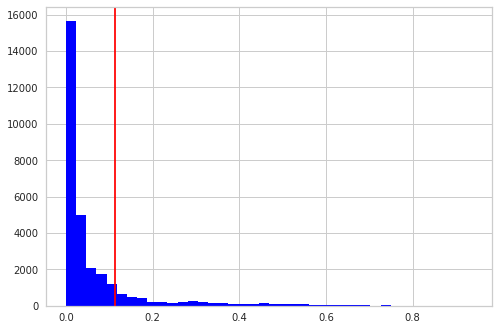

In [36]:
# Plot the predicted probabilities of default
plt.hist(prob_pos_isotonic, color = 'blue', bins = 40)

# Calculate the threshold with quantile
threshold = np.quantile(prob_pos_isotonic, 0.85)

# Add a reference line to the plot for the threshold
plt.axvline(x = threshold, color = 'red')
plt.show()

## Bad rates
With acceptance rate in mind, you can now analyze the bad rate within the accepted loans. This way you will be able to see the percentage of defaults that have been accepted.

Think about the impact of the acceptance rate and bad rate. We set an acceptance rate to have fewer defaults in the portfolio because defaults are more costly. Will the bad rate be less than the percentage of defaults in the test data?

In [37]:
X_test.shape , y_test.shape,prob_pos_isotonic.shape

((30000, 74), (30000,), (30000,))

In [38]:
# Calculate the threshold for a 85% acceptance rate
threshold_85 = np.quantile(prob_pos_isotonic, 0.85)
test_pred_df= pd.DataFrame(data=prob_pos_isotonic, columns=['prob_default'])
# Check the statistics of the probabilities 
print( test_pred_df['prob_default'].describe())
# Apply acceptance rate threshold
test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > threshold_85 else 0)

# Print the counts of loan status after the threshold
print(test_pred_df['pred_loan_status'].value_counts())

count    30000.000000
mean         0.066915
std          0.114715
min          0.000313
25%          0.010150
50%          0.021468
75%          0.067022
max          0.936627
Name: prob_default, dtype: float64
0    25502
1     4498
Name: pred_loan_status, dtype: int64


In [39]:
# Print the top 5 rows of the new data frame
test_pred_df['true_loan_status']=y_test.to_numpy()
print(test_pred_df.head())
print(test_pred_df.info())
# Create a subset of only accepted loans
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
# Calculate the bad rate
print(np.sum(accepted_loans['true_loan_status']) / accepted_loans['true_loan_status'].count())

   prob_default  pred_loan_status  true_loan_status
0      0.010697                 0                 0
1      0.018617                 0                 0
2      0.003965                 0                 0
3      0.011260                 0                 0
4      0.011260                 0                 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   prob_default      30000 non-null  float64
 1   pred_loan_status  30000 non-null  int64  
 2   true_loan_status  30000 non-null  int8   
dtypes: float64(1), int64(1), int8(1)
memory usage: 498.2 KB
None
0.02639008705199592


In [40]:
accept_rates=[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]
# Print accept rates
print(accept_rates)

[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]


In [41]:
test_pred_df= pd.DataFrame(data=prob_pos_isotonic, columns=['prob_default'])
test_pred_df['true_loan_status']=y_test.to_numpy()
# Populate the arrays for the strategy table with a for loop
thresholds=[]
bad_rates=[]
for rate in accept_rates:
  	# Calculate the threshold for the acceptance rate
    thresh = np.quantile(prob_pos_isotonic, rate).round(3)
    # Add the threshold value to the list of thresholds
    thresholds.append(np.quantile(prob_pos_isotonic, rate).round(3))
    # Reassign the loan_status value using the threshold
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(3))

In [42]:
# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Acceptance Rate','Threshold','Bad Rate'])

# Print the entire table
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate
0              1.00      0.937     0.067
1              0.95      0.329     0.045
2              0.90      0.176     0.034
3              0.85      0.114     0.026
4              0.80      0.088     0.022
5              0.75      0.067     0.019
6              0.70      0.050     0.016
7              0.65      0.039     0.013
8              0.60      0.032     0.012
9              0.55      0.027     0.011
10             0.50      0.021     0.010
11             0.45      0.018     0.009
12             0.40      0.015     0.007
13             0.35      0.012     0.006
14             0.30      0.011     0.006
15             0.25      0.010     0.005
16             0.20      0.009     0.005
17             0.15      0.007     0.004
18             0.10      0.005     0.004
19             0.05      0.003     0.003


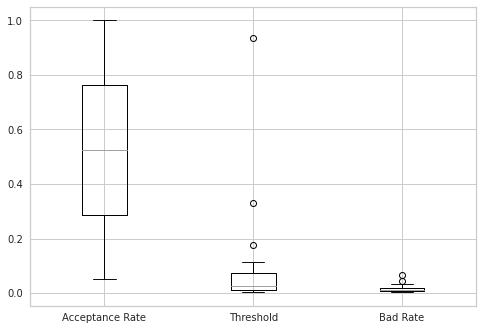

In [43]:
# Visualize the distributions in the strategy table with a boxplot
strat_df.boxplot()
plt.show()

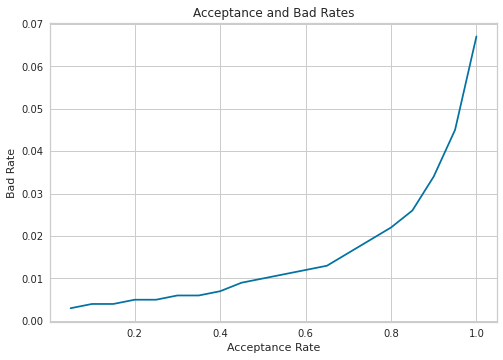

In [44]:
# Plot the strategy curve
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.show()

# Let's do Deep study of Calibration : 
Next, we will fit a lgbm model to our training data. Then we'll use that model to predict "probabilities" on our validation and test sets.

I use quotes on "probabilities" because these numbers, which are the percentage of trees that voted "yes" are better understood as mere scores. A higher value should generally indicate a higher probability of mortality. However, in general, one should not expect these to be well-calibrated probabilities. The fact that, say, 60% of the trees voted "yes" on a particular case does not necessarily mean that  case has a 60% probability of mortality.


##  Log-loss (aka Cross-Entropy aka Negative Mean Log-Likelihood)

The log_loss is a common metric to measure the "quality" of predicted probabilities
AUROC measures the quality of the ranking but does not assess calibration

log_loss assesses the combination of discrimination and calibration.

log_loss is difficult to interpret on its own, generally used comparatively.

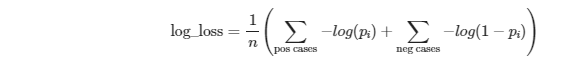

- If you predicted a probability of .25 for a case, and it happened, your loss for that case would be $-\\log(.25) = \\log(1/.25) = \\log(4)$

- If you predicted a probability of .8 for a case, and it *didn't* happen, your loss for that case would be $-\\log(1-.8) = \\log(1/.2) = \\log(5)$

- Loss is 0 when you are certain about the outcome and you are right,

- Loss is $\\infty$ when you are certain about the outcome and you are wrong\n"



In [45]:
# Gaussian Logistic Regression  with no calibration
clf = model_lgbm2

clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_uncalib = clf.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


In [46]:
roc_auc_score(y_test, prob_uncalib), log_loss(y_test, prob_uncalib),brier_score_loss(y_test, prob_uncalib)

(0.8673752749756257, 0.17664639365409507, 0.04879177395905705)

##   Log-loss vs Brier Score

The main difference between Brier score and log-loss is how they deal with small probabilities. Suppose the "true" probability is .01 and you predict a probability of .0001, is that a "big" error?

According to log-loss, it is. You have understated the true probability by a factor of 100. If you were working in insurance, and predicting the probability of a car accident, the insurance company would be paying out 100x as much as they thought they would.

According to Brier score, it is not that a big deal. For some applications, that may be appropriate. For example, if you are modeling the probability someone will vote for Candidate A vs Candidate B, and planning to use that model to estimate election results on some population, it doesn't matter to distinguish between very low probabilities.

This is actually a very "deep" topic. We will focus primarily on the log-loss, but will also show the results on Brier score.

## Reliability Diagram
Here i will use other preprpared lib to repeat what we have doone  .

A visual way to check the calibration of a model is to create a "Reliability Diagram". The idea behind the reliability diagram is the following:

1. Bin the interval [0,1] into smaller subsets (e.g. [0, 0.05], [0.05, .1], ... [.95,1])

1. Find the empirical probabilities when the probabilities fell into each bin (if there were 20 times, and 9 of them were "yes", the empirical probability is .45)

1. Plot the predicted probability (average of predicted probabilities in each bin) (x-axis) vs the empirical probabilities(y-axis)

1. When the dots are (significantly) above the line y=x, the model is under-predicting the true probability, if below the line, model is over-predicting the true probability.

We will use the ml-insights *plot_reliability_diagram* function. It has a fair bit of flexibility that we will explore. Some features include:


* custom bins

* accompanying histogram

* error bars

* logit scaling to explore calibration of very small and very large probabilities


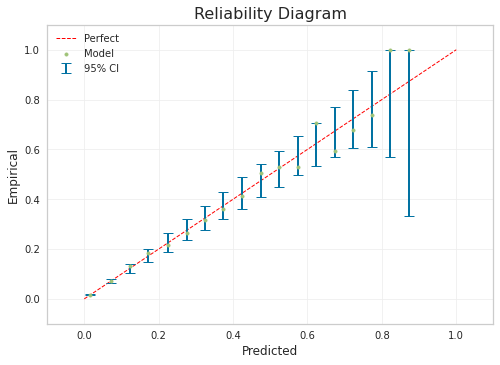

In [47]:
# This is the default plot
rd = mli.plot_reliability_diagram(y_test, prob_uncalib,baseline_color='red')

{'pred_probs': array([0.01673121, 0.07063986, 0.12183258, 0.17220285, 0.2246325 ,
        0.27633316, 0.32417005, 0.37387989, 0.42460849, 0.47485043,
        0.52311685, 0.57386736, 0.6230056 , 0.6735292 , 0.72266325,
        0.77383854, 0.8205618 , 0.87406911]),
 'emp_probs': array([0.01628788, 0.07139175, 0.13095238, 0.18282209, 0.21765914,
        0.26419753, 0.31794872, 0.36170213, 0.41463415, 0.50458716,
        0.52747253, 0.52795031, 0.70491803, 0.59340659, 0.67857143,
        0.73913043, 1.        , 1.        ]),
 'bin_counts': array([2.112e+04, 3.880e+03, 1.512e+03, 8.150e+02, 4.870e+02, 4.050e+02,
        3.900e+02, 2.820e+02, 2.460e+02, 2.180e+02, 1.820e+02, 1.610e+02,
        1.220e+02, 9.100e+01, 5.600e+01, 2.300e+01, 7.000e+00, 3.000e+00])}

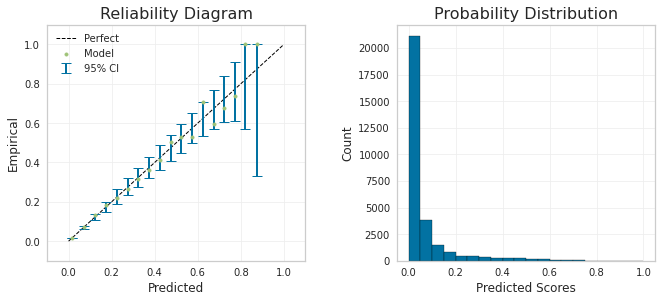

In [48]:
# You can opt to have a histogram showing the counts in each bin
plt.figure(figsize=(10,5))
mli.plot_reliability_diagram(y_test, prob_uncalib, show_histogram=True)

We see that we have lots of observations with small predicted probabilities and fewer with large probabilities. Suppose we want to subdivide further the bins where we have lots of data, and aggregate the bins that have less data.

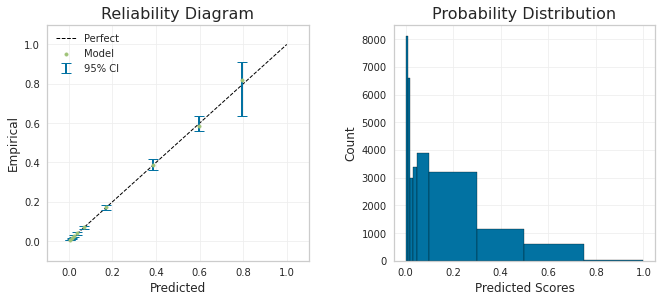

In [49]:
plt.figure(figsize=(10,5))
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .3, .5, .75, 1])
mli.plot_reliability_diagram(y_test, prob_uncalib, bins=custom_bins_a, show_histogram=True);

Again, we may be underpredicting close to 0, but it is hard to tell. To look closer, we can use the "logit" scaling. This scaling uses more area at probabilities close to 0 and 1, and less area close to .5

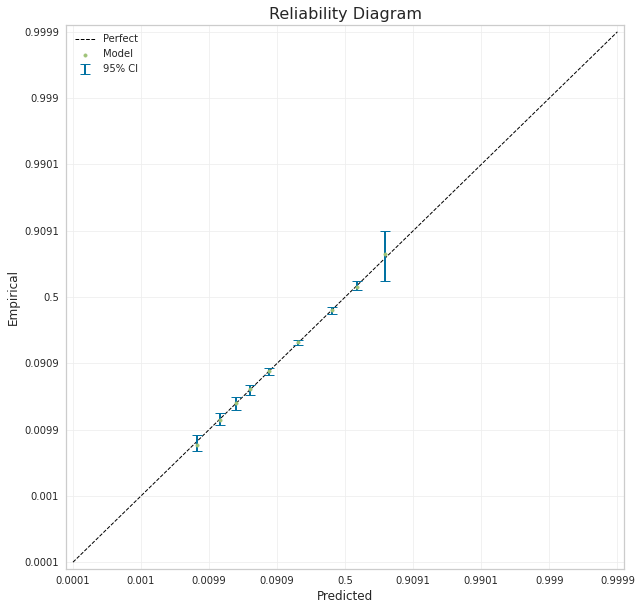

In [50]:
plt.figure(figsize=(10,10))
rd = mli.plot_reliability_diagram(y_test, prob_uncalib, scaling='logit',
                                 bins=custom_bins_a, marker='.')

#  Calibrating a Model
Since our models are not well-calibrated, we would like to fix this.

Getting a Calibration Data Set

We will discuss two ways to get a data set on which to perform calibration:

1. Use an independent calibration set
1. Using Cross-validation to generate scores from the training set.

The first method is simpler, but requires a separate data set, meaning that you will have less data to train your model with. It is good to use if you have plenty of data.

The second approach takes more time, but is generally more data-efficient. We generate a set of cross-validated predictions on the training data. These predictions come from models that are close to, but not exactly identical to, your original model. However, this discrepancy is usually minor and offset by having more data on which to calibrate.


##  Method of Calibration
The data set for calibration is a set of scores and the corresponding binary outcomes. The goal is then to find a function that "fits" the relationship between the scores and the "actual" probabilities (as determined empirically in the calibration set. We will review 4 methods of calibration:

1. Platt Scaling
1. Beta Calibration
1. Isotonic Regression
1. SplineCa

credit : https://github.com/numeristical/resources/blob/master/CalibrationWorkshop/Calibration_Workshop_1.ipynb


# CV  Calibration  

In [51]:
# Gaussian Logistic Regression  with no calibration
clf = model_lgbm2

clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(X_test)[:, 1]


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


In [52]:
# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=5, method="isotonic")
clf_isotonic.fit(X_train, y_train
                #,sample_weight=sw_train
               )
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


In [53]:
clf_sigmoid = CalibratedClassifierCV(clf, cv=5, method="sigmoid")
clf_sigmoid.fit(X_train, y_train
                #,sample_weight=sw_train
               )
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


In [54]:
# Get the cross validated predictions given a model and training data.
cv_preds_train = mli.cv_predictions(pipe1_model_lgbm_woe_powertransformer2, X, y, clone_model=True)
cv_preds_train1 = cv_preds_train[:,1]

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


In [55]:
# Fit Platt scaling (logistic calibration)
lr_cv = LogisticRegression(C=99999999999, solver='lbfgs')
lr_cv.fit(cv_preds_train1.reshape(-1,1), y)
testset_platt_probs_cv = lr_cv.predict_proba(prob_pos_clf.reshape(-1, 1))[:,1]

In [56]:
iso_cv = IsotonicRegression(out_of_bounds = 'clip')
iso_cv.fit(cv_preds_train1, y)
testset_iso_probs_cv = iso_cv.predict(prob_pos_clf)

In [57]:
# Fit three-parameter beta calibration
bc_cv = BetaCalibration()
bc_cv.fit(cv_preds_train1, y)
testset_bc_probs_cv = bc_cv.predict(prob_pos_clf)

In [58]:
splinecalib_cv = mli.SplineCalib()
splinecalib_cv.fit(cv_preds_train1, y)
testset_splinecalib_probs_cv = splinecalib_cv.predict(prob_pos_clf)

In [59]:
print('Uncalibrated log_loss = {}'.format(log_loss(y_test, prob_pos_clf)))
print('Sklearn_isotonicCV  log_loss = {}'.format(log_loss(y_test, prob_pos_isotonic)))
print('Sklearn_sigmoidCV  log_loss = {}'.format(log_loss(y_test, prob_pos_sigmoid)))
print('Platt calibratedCV  log_loss = {}'.format(log_loss(y_test, testset_platt_probs_cv)))
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_test, testset_iso_probs_cv)))
print('Beta calibrated log_loss = {}'.format(log_loss(y_test, testset_bc_probs_cv)))

Uncalibrated log_loss = 0.17664639365409507
Sklearn_isotonicCV  log_loss = 0.17656333987022307
Sklearn_sigmoidCV  log_loss = 0.18648237527891506
Platt calibratedCV  log_loss = 0.1870035097520309
Isotonic calibrated log_loss = 0.17677079951990968
Beta calibrated log_loss = 0.17664204745184897


In [60]:
print('Uncalibrated brier_score_loss = {}'.format(brier_score_loss(y_test, prob_pos_clf)))
print('Sklearn_isotonicCV  brier_score_loss = {}'.format(brier_score_loss(y_test, prob_pos_isotonic)))
print('Sklearn_sigmoidCV brier_score_loss = {}'.format(brier_score_loss(y_test, prob_pos_sigmoid)))
print('Platt calibratedCV  brier_score_loss = {}'.format(brier_score_loss(y_test, testset_platt_probs_cv)))
print('Isotonic calibrated brier_score_loss = {}'.format(brier_score_loss(y_test, testset_iso_probs_cv)))
print('Beta calibrated brier_score_loss = {}'.format(brier_score_loss(y_test, testset_bc_probs_cv)))

Uncalibrated brier_score_loss = 0.04879177395905705
Sklearn_isotonicCV  brier_score_loss = 0.04877376069578235
Sklearn_sigmoidCV brier_score_loss = 0.04998939845045162
Platt calibratedCV  brier_score_loss = 0.05015000387572695
Isotonic calibrated brier_score_loss = 0.04884809045309262
Beta calibrated brier_score_loss = 0.048796970588146665


In [61]:
print('Uncalibrated roc_auc_score = {}'.format(roc_auc_score(y_test, prob_pos_clf)))
print('Sklearn_isotonicCV  roc_auc_score = {}'.format(roc_auc_score(y_test, prob_pos_isotonic)))
print('Sklearn_sigmoidCV roc_auc_score = {}'.format(roc_auc_score(y_test, prob_pos_sigmoid)))
print('Platt calibratedCV  roc_auc_score = {}'.format(roc_auc_score(y_test, testset_platt_probs_cv)))
print('Isotonic calibrated roc_auc_score = {}'.format(roc_auc_score(y_test, testset_iso_probs_cv)))
print('Beta calibratedroc_auc_score = {}'.format(roc_auc_score(y_test, testset_bc_probs_cv)))

Uncalibrated roc_auc_score = 0.8673752749756257
Sklearn_isotonicCV  roc_auc_score = 0.8675733598669874
Sklearn_sigmoidCV roc_auc_score = 0.8675909084228169
Platt calibratedCV  roc_auc_score = 0.8673752749756257
Isotonic calibrated roc_auc_score = 0.8670048579212801
Beta calibratedroc_auc_score = 0.8673752749756257


# Final Calibrated Pipe : 


In [62]:
isotonic_clib = CalibratedClassifierCV(model_lgbm2, cv=10, method="isotonic")
pipe1_model_lgbm_woe_powertransformer2_clib = Pipeline(
    steps=[
        ('preprocessor', preprocessor_woe_powertransformer),
         ('reducedim',  SelectPercentile( f_classif, percentile=95)),
        # ('dim_red', SelectKBest(f_regression, k=20)),
        #('Sparseinteractions', SparseInteractions(degree=2)),
         #('PolynomialFeatures', PolynomialFeatures(degree=2)),
        #('PCAreducer', PCA(n_components=0.8)),
        ('classifier',isotonic_clib)
    ]
)
pipe1_model_lgbm_woe_powertransformer2_clib

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   PowerTransformer()),
                                                                  ('kmeans',
                                                                   MiniKmeansTransformerEncoder()),
                                                                  ('polynominal_features',
                                                                   PolynomialFeatures())]),
                                                  Index(['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome'...
       'NumberOfTime30-59DaysPastDueNotWorse', 'age'],
      dtype='object'))])),
                ('reducedim', SelectPercentile(percentile=95)),
                ('classifier',
                 CalibratedClassifierCV(base_estimator=LGBMClassifier(learning_rate=0.0018069834369607075,
                                                                      max_depth=8,
                                                                      metric='auc',
                                                                      min_samples_leaf=47,
                                                                      n_estimators=5000,
                                                                      random_state=42,
                                                                      subsample=0.8573598985000007,
                                                                      verbose=-1),
                                        cv=10, method='isotonic'))])

In [63]:
%%time 
def plot_roc(y,y_pred):
    from sklearn.metrics import auc
    fpr, tpr, thresholds = roc_curve(y_true=y, y_score=y_pred)
    auc = auc(fpr, tpr)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Model(area = {:.3f})'.format(auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


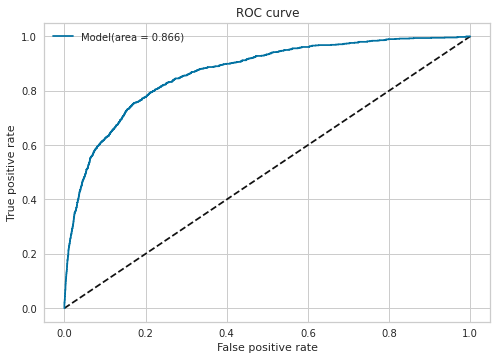

Confusion_matrix:
 [[13877   120]
 [  817   186]]
Fold 0 | AUC: 0.8664654390048403
Fold 0 | F1: 0.28418640183346067
Fold 0 | Avergae_precesion: 0.40386908369850805
Fold 0 | recall: 0.18544366899302095
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     13997
           1       0.61      0.19      0.28      1003

    accuracy                           0.94     15000
   macro avg       0.78      0.59      0.63     15000
weighted avg       0.92      0.94      0.92     15000

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


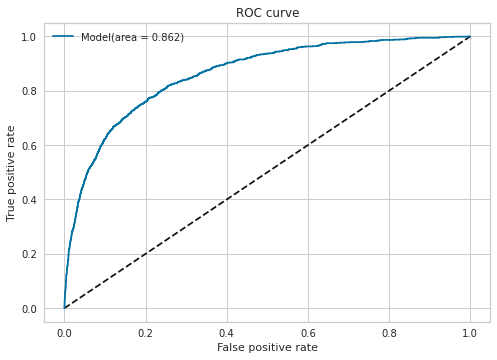

Confusion_matrix:
 [[13848   149]
 [  802   201]]
Fold 1 | AUC: 0.8619234103077635
Fold 1 | F1: 0.29711751662971175
Fold 1 | Avergae_precesion: 0.38201333870134047
Fold 1 | recall: 0.20039880358923232
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     13997
           1       0.57      0.20      0.30      1003

    accuracy                           0.94     15000
   macro avg       0.76      0.59      0.63     15000
weighted avg       0.92      0.94      0.92     15000

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


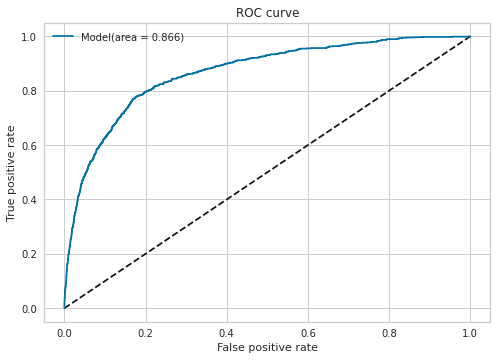

Confusion_matrix:
 [[13842   155]
 [  800   203]]
Fold 2 | AUC: 0.8664904051865266
Fold 2 | F1: 0.29831006612784716
Fold 2 | Avergae_precesion: 0.40248955928403385
Fold 2 | recall: 0.2023928215353938
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     13997
           1       0.57      0.20      0.30      1003

    accuracy                           0.94     15000
   macro avg       0.76      0.60      0.63     15000
weighted avg       0.92      0.94      0.92     15000

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


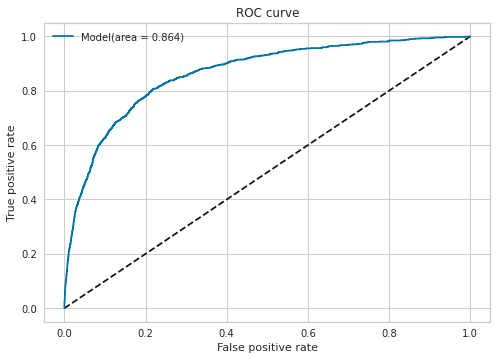

Confusion_matrix:
 [[13851   146]
 [  808   195]]
Fold 3 | AUC: 0.8637875400019845
Fold 3 | F1: 0.29017857142857145
Fold 3 | Avergae_precesion: 0.39620367605189816
Fold 3 | recall: 0.19441674975074777
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     13997
           1       0.57      0.19      0.29      1003

    accuracy                           0.94     15000
   macro avg       0.76      0.59      0.63     15000
weighted avg       0.92      0.94      0.92     15000

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


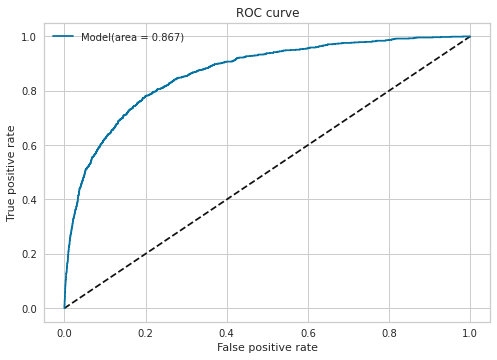

Confusion_matrix:
 [[13861   136]
 [  799   204]]
Fold 4 | AUC: 0.8665599614673163
Fold 4 | F1: 0.3037974683544304
Fold 4 | Avergae_precesion: 0.40176461036183536
Fold 4 | recall: 0.2033898305084746
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     13997
           1       0.60      0.20      0.30      1003

    accuracy                           0.94     15000
   macro avg       0.77      0.60      0.64     15000
weighted avg       0.92      0.94      0.92     15000

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


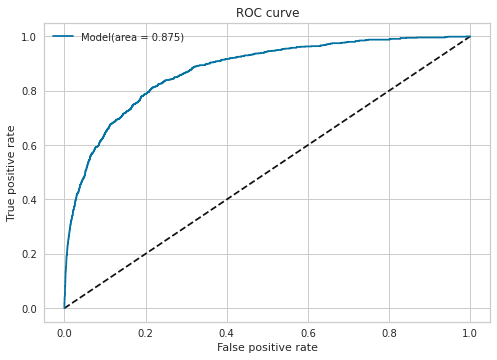

Confusion_matrix:
 [[13901    96]
 [  794   209]]
Fold 5 | AUC: 0.8746495029450478
Fold 5 | F1: 0.3195718654434251
Fold 5 | Avergae_precesion: 0.4403356779216047
Fold 5 | recall: 0.20837487537387836
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     13997
           1       0.69      0.21      0.32      1003

    accuracy                           0.94     15000
   macro avg       0.82      0.60      0.64     15000
weighted avg       0.93      0.94      0.93     15000

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


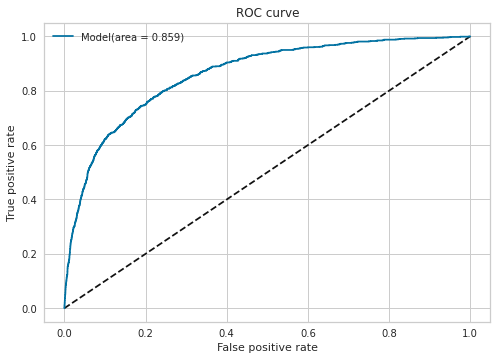

Confusion_matrix:
 [[13852   146]
 [  833   169]]
Fold 6 | AUC: 0.8591249420005538
Fold 6 | F1: 0.25664388762338647
Fold 6 | Avergae_precesion: 0.36530109536816685
Fold 6 | recall: 0.1686626746506986
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     13998
           1       0.54      0.17      0.26      1002

    accuracy                           0.93     15000
   macro avg       0.74      0.58      0.61     15000
weighted avg       0.92      0.93      0.92     15000

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


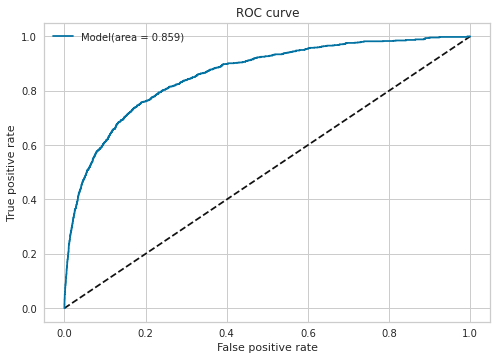

Confusion_matrix:
 [[13865   133]
 [  801   201]]
Fold 7 | AUC: 0.859476824319642
Fold 7 | F1: 0.3008982035928144
Fold 7 | Avergae_precesion: 0.4044608753381401
Fold 7 | recall: 0.20059880239520958
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     13998
           1       0.60      0.20      0.30      1002

    accuracy                           0.94     15000
   macro avg       0.77      0.60      0.63     15000
weighted avg       0.92      0.94      0.92     15000

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


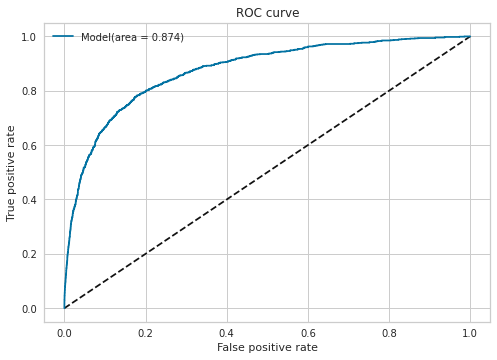

Confusion_matrix:
 [[13887   111]
 [  805   197]]
Fold 8 | AUC: 0.8743813986543274
Fold 8 | F1: 0.300763358778626
Fold 8 | Avergae_precesion: 0.4413855426133532
Fold 8 | recall: 0.1966067864271457
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     13998
           1       0.64      0.20      0.30      1002

    accuracy                           0.94     15000
   macro avg       0.79      0.59      0.63     15000
weighted avg       0.92      0.94      0.92     15000

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


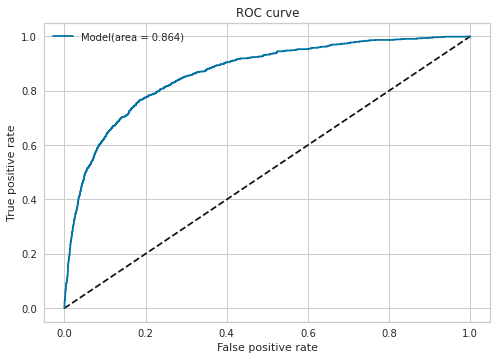

Confusion_matrix:
 [[13855   143]
 [  830   172]]
Fold 9 | AUC: 0.863910484503204
Fold 9 | F1: 0.2611996962794229
Fold 9 | Avergae_precesion: 0.37558448373864195
Fold 9 | recall: 0.17165668662674652
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     13998
           1       0.55      0.17      0.26      1002

    accuracy                           0.94     15000
   macro avg       0.74      0.58      0.61     15000
weighted avg       0.92      0.94      0.92     15000

--------------------------------------------------------------------------------

Overall mean AUC score : 0.8656769908391206

Overall mean F1 score : 0.2912667036091696

Overall mean average precision score : 0.4013407943077523

Overall mean recall score : 0.19319416998505484
CPU times: user 1h 35min 34s, sys: 20.7 s, total: 1h 35min 54s
Wall time: 24min 48s


In [64]:
%%time 
###############################################################################
#                         CV                                                 #
###############################################################################
# evaluate each strategy on the dataset
results = list()
# Setting a 10-fold stratified cross-validation (note: shuffle=True)
SEED = 42
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
# CV interations
# Create arrays for the features and the response variable
roc_auc = list()
average_precision = list()
#X1=X.iloc[0:2000,:].copy()
#y1=y[0:2000].copy()
oof = np.empty((X.shape[0],))
#oof = np.empty((x_rus.shape[0],))
#oof_bin = np.empty((X.shape[0],))
predictions=[]
mean_auc = 0
mean_ap=0
F1 = list()
Recall=list()
best_iteration = list()
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):    
    X_train, y_train =X.iloc[list(train_idx),:], y[list(train_idx)]
    X_test, y_test = X.iloc[list(test_idx),:],y[list(test_idx)]
    pipe1_model_lgbm_woe_powertransformer2.fit(X_train,y_train,
                                                  #classifier__verbose=False
                                                  #,verbose=False
              #sample_weight=np.where(y_train==1,1,4)
              #sample_weight=np.where(y_train==1,4,1)
              #sample_weight=np.where(y_train==1,14,1)      
                                                 )
    preds = pipe1_model_lgbm_woe_powertransformer2.predict_proba(X_test)[:,1]
    oof[test_idx] = preds
    auc_score= roc_auc_score(y_true=y_test, y_score=preds)
    roc_auc.append(auc_score)
    ap=average_precision_score(y_true=y_test, y_score=preds)
    plot_roc(y_test,preds)
    mean_auc += auc_score / FOLDS
    mean_ap+=ap/FOLDS
    predictions.append(pipe1_model_lgbm_woe_powertransformer2.predict_proba(X_test_final)[:,1]) 
    y_predicted =pipe1_model_lgbm_woe_powertransformer2.predict(X_test)
    recall = recall_score(y_test, y_predicted)
    f1= f1_score(y_test, y_predicted)
    print('Confusion_matrix:\n',confusion_matrix(y_test,y_predicted))
    print(f"Fold {fold} | AUC: {auc_score}")
    print(f"Fold {fold} | F1: {f1}")
    print(f"Fold {fold} | Avergae_precesion: {ap}")
    print(f"Fold {fold} | recall: {recall}")
    print('Classification report:\n',classification_report(y_test,y_predicted))
    roc_auc.append(auc_score)
    F1.append(f1)
    Recall.append(recall)
    #Mean of the predictions
print('-' * 80)  
print(f"\nOverall mean AUC score : {mean_auc}")
print(f"\nOverall mean F1 score : {np.mean(F1)}")
print(f"\nOverall mean average precision score : {mean_ap}")
print(f"\nOverall mean recall score : {np.mean(Recall)}")

In [65]:
###############################################################################
#                         Final Evaluation                                    #
###############################################################################

                      
###############################################################################
#                         Preprocess                                          #
###############################################################################
#preprocessor_woe_powertransformer_final.fit(X,y)
#x_pre = preprocessor_woe_powertransformer_final.transform(X)
#x_test_final_pre = preprocessor_woe_powertransformer_final.transform(X_test_final)
#isotonic = CalibratedClassifierCV(model_lgbm2, cv=12, method="isotonic")
pipe1_model_lgbm_woe_powertransformer2_clib.fit(X, y
                #,sample_weight=sw_train
              )
predictions_calib = pipe1_model_lgbm_woe_powertransformer2_clib.predict_proba(X_test_final)[:, 1]
#predictions = np.mean(np.column_stack(predictions), axis=1)
# Save the predictions to a CSV file
sub = pd.read_csv('../input/GiveMeSomeCredit/sampleEntry.csv')
sub['Probability']=predictions_calib
sub.to_csv('sclf1.csv', index=False)
sub

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=47, min_child_samples=20 will be ignored. Current value: min_data_in_

,Id,Probability
0,1,0.061566
1,2,0.037714
2,3,0.016066
3,4,0.083734
4,5,0.122008
...,...,...
101498,101499,0.029926
101499,101500,0.406757
101500,101501,0.004777
101501,101502,0.058758


# Summuary : 
Model calibration is another method we will use to compare models is to check how well calibrated their predicted probabilities are. What this means is we want to be able to interpret these probabilities as a confidence level for default. A model is well-calibrated when a sample of loans has an average predicted probability of default close to that sample's percentage of actual defaults. For example, if we take 10 loans and their average predicted probability of default is 0.12, we expect 12% of the sample to be defaults. If our model has an average predicted probability of default of 0.25 and that sample is 65% defaults, then we have several loans that we predicted to be non-default that are actually defaults which we are very costly.
credit : 




https://www.youtube.com/watch?v=FkfDlOnQVvQ

https://www.youtube.com/watch?v=hWb-MIXKe-s

https://www.youtube.com/watch?v=AunotauS5yI

https://www.youtube.com/watch?v=w3OPq0V8fr8

https://github.com/DeepSparkChaker/Credit_Risk_Small_Data_SyntheticSamples_EnsembleMethods/blob/main/Credit_Risk_Anaysis%20.ipynb


https://github.com/numeristical/resources/tree/master/CalibrationWorkshop

https://github.com/numeristical/resources/blob/master/CalibrationWorkshop/Calibration_Workshop_1.ipynb
https://github.com/numeristical/resources/blob/master/CalibrationWorkshop/Calibration_Workshop_1.ipynb
https://github.com/numeristical/resources/tree/master/CalibrationWorkshop


https://github.com/DeepSparkChaker/machine-learning-imbalanced-data/tree/master/Section-09-Probability-Calibration

https://campus.datacamp.com/courses/credit-risk-modeling-in-python/model-evaluation-and-implementation?ex=9

https://github.com/DeepSparkChaker/Credit_Risk_Small_Data_SyntheticSamples_EnsembleMethods/blob/main/Credit_Risk_Anaysis%20.ipynb